In [49]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import numpy as np
import torch as tr

In [51]:
from torch import optim
from matplotlib import style
from matplotlib import pyplot as plt
style.use(style.available[14])

In [52]:
from utils import viz_utils
from modules.commons import SingleZTransform
from models.losses import x_clf_loss_2, x_clf_loss

In [53]:
def sample(net, n_samples=4000):
    X = np.random.normal(0, 1, (n_samples, 2))
    X = net.denormalize(tr.tensor(X, dtype=tr.float32))
    return X

In [54]:
mu1 = np.array([2.0, 3.0])
sigma1 = np.array([[2.0, 1.5], [1.5, 2.0]])

mu2 = np.array([3.0, 2.0])
sigma2 = np.array([[3.0, -1.5], [-1.5, 4.0]])

w1 = tr.tensor(0.5, dtype=tr.float32)
w2 = tr.tensor(0.5, dtype=tr.float32)

In [55]:
def compute_loss_1():
    x1 = sample(net1)
    x2 = sample(net2)
    loss = x_clf_loss_2(net1.means, net1.cov, w1, net2.means, net2.cov, w2, x1, x2)
    return loss

def compute_loss_2():
    x1 = sample(net1)
    x2 = sample(net2)
    x = tr.cat([x1, x2])
    loss = x_clf_loss(net1.means, net1.cov, w1, net2.means, net2.cov, w2, x)
    return loss

def draw_eclipse(ax):
    with tr.no_grad():
        x1 = sample(net1)
        x2 = sample(net2)
        
        mu1, sigma1 = net1.params
        mu2, sigma2 = net2.params
        
        mu1 = mu1.detach().numpy()
        mu2 = mu2.detach().numpy()
        sigma1 = sigma1.detach().numpy()
        sigma2 = sigma2.detach().numpy()
        
        viz_utils.plot_ellipse(ax, mu1, sigma1, color='blue')
        viz_utils.plot_ellipse(ax, mu2, sigma2, color='red')
        viz_utils.scatter_2d(ax, x1, c='blue', s=1)
        viz_utils.scatter_2d(ax, x2, c='red', s=1)

In [70]:
# Networks
net1 = SingleZTransform((tr.tensor(mu1), tr.tensor(sigma1)), mean_grad=True, cov_grad=True)
net2 = SingleZTransform((tr.tensor(mu2), tr.tensor(sigma2)), mean_grad=True, cov_grad=True)

params = [a for net in [net1, net2] for a in net.parameters()]
opt = optim.Adam(params)
losses = []
i = 0
seperate = False

In [71]:
for _ in range(1000):
    i += 1
    opt.zero_grad()
    if seperate:
        loss = compute_loss_1()
    else:
        loss = compute_loss_2()
    loss.backward()
    opt.step()
    
    losses.append(loss)
    
    if i % 10 == 0:
        if i % 100 == 0:
            print 'iter: ', i+1
        ax = plt.gca()
        ax.set_xlim(-10, 10)
        ax.set_ylim(-10, 10)
        draw_eclipse(ax)
        tag = 'seperate' if seperate else 'joint'
        plt.savefig('L_CE/%s_%05d' % (tag, i+1))
        plt.close()

iter:  101
iter:  201
iter:  301
iter:  401


RuntimeError: Lapack Error in potrf : the leading minor of order 2 is not positive definite at /pytorch/aten/src/TH/generic/THTensorLapack.cpp:626

ZParams(means=Parameter containing:
tensor([1.7738, 3.2294], requires_grad=True), cov=Parameter containing:
tensor([[1.7519, 1.7517],
        [1.7527, 1.7533]], requires_grad=True))
ZParams(means=Parameter containing:
tensor([3.2262, 1.7706], requires_grad=True), cov=Parameter containing:
tensor([[ 3.1895, -1.6431],
        [-1.6692,  4.1512]], requires_grad=True))


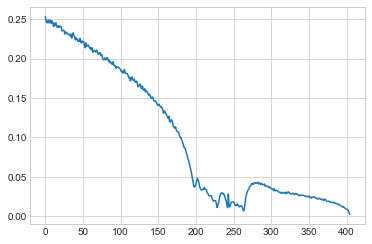

In [72]:
print net1.params
print net2.params

plt.plot(losses)

In [27]:
draw_eclipse(ax)

utils/np_utils.py:37: RuntimeWarning: invalid value encountered in sqrt
  b = np.sqrt((trace - np.sqrt(trace ** 2 - 4 * det)) / 2.0)
